In [2]:
import pandas as pd
import gensim           # NLP Package, topic modelling, document indexing and similarity retrieval with large corpora
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb    #an implementation of gradient boosted decision trees designed for speed and performance

In [3]:
# Set options for pandas

def start():
    options = {
        'display': {
            'max_columns': None,
            'max_colwidth': 25,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 14,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            pd.set_option(f'{category}.{op}', value)  # Python 3.6+

start()

In [4]:
#reading file 
main_data = pd.read_csv('N:\\Study Stuff\\News-headlines-analysis\\News_Final.csv')

In [5]:
main_data.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at ...,Obama Lays Wreath at ...,USA TODAY,obama,2002-04-02 00:00:00,0.0000,-0.0533,-1,-1,-1
1,10423.0,A Look at the Health ...,"Tim Haywood, investme...",Bloomberg,economy,2008-09-20 00:00:00,0.2083,-0.1564,-1,-1,-1
2,18828.0,Nouriel Roubini: Glob...,"Nouriel Roubini, NYU ...",Bloomberg,economy,2012-01-28 00:00:00,-0.4252,0.1398,-1,-1,-1
3,27788.0,Finland GDP Expands I...,Finland's economy exp...,RTT News,economy,2015-03-01 00:06:00,0.0000,0.0261,-1,-1,-1
4,27789.0,"Tourism, govt spendin...",Tourism and public sp...,The Nation - Thailand...,economy,2015-03-01 00:11:00,0.0000,0.1411,-1,-1,-1


In [6]:
# Pre-processing of Data
# Fetching all the article titles

article_titles = main_data['Title']
article_titles.shape        # returns the number of rows

(93239,)

In [7]:
# Create a list of strings, where each string is an article title
titles_list = [title for title in article_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

# splitting sentences and words from the body of the text
from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation, converting into lower case
# Checking if each string contains alphabets and no numerics, isalpha() 
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['obama',
 'lays',
 'wreath',
 'arlington',
 'national',
 'cemetery',
 'look',
 'health',
 'chinese',
 'economy']

In [9]:
# Load Word2Vec model, pre trained on about 100 billion words (trained on an enormous Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('C:\\Users\\rockn\\Downloads\\Compressed\\GoogleNews-vectors-negative300.bin\\GoogleNews-vectors-negative300.bin', binary = True) 

# Check dimension of word vectors
model.vector_size

300

In [11]:
#testing how a word vector looks like
trade_vec = model['trade']
trade_vec[:20] # First 20 components

# it can create a vector only if its present its vocabulary

array([ 0.03564453,  0.22265625, -0.12255859,  0.04321289,  0.18164062,
        0.03759766, -0.10107422, -0.0703125 ,  0.0703125 ,  0.06640625,
       -0.18164062, -0.05834961, -0.08154297, -0.06054688, -0.09863281,
       -0.01348877,  0.07617188,  0.20117188,  0.21484375, -0.19824219],
      dtype=float32)

In [12]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.shape

(21805, 300)

In [14]:
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
obama,-0.1235,0.0723,0.1719,0.4023,-0.1260,-0.3027,-0.0449,-0.0153,0.1719,-0.0435,-0.1328,-0.4590,-0.5273,0.1396,-0.1235,0.4219,-0.1465,0.0413,0.0299,-0.3574,0.0444,-0.0938,0.4258,-0.1543,-0.2295,0.3008,-0.4277,-0.0801,0.3164,-0.2021,0.1035,0.2061,-0.3184,-0.0908,-0.0581,0.0996,-0.2256,0.0630,0.2002,0.1680,0.0233,-0.2451,0.3672,0.0840,0.1211,0.1582,0.3594,-0.3320,-0.2598,-0.0337,-0.1357,-0.0903,0.1943,0.0884,0.2520,0.0496,-0.3027,-0.0820,0.1807,-0.2988,0.1768,0.2021,-0.2793,-0.1377,0.0415,-0.2949,-0.1250,-0.3301,-0.2100,0.0366,0.1328,0.5625,0.1807,0.1543,-0.1250,-0.2236,0.3301,0.0903,-0.1777,0.0019,-0.1621,0.3223,-0.0977,-0.0544,0.1738,0.0066,-0.2715,0.1943,0.0238,0.0854,-0.0674,0.1504,-0.0811,-0.3125,-0.1963,0.1611,-0.2354,-0.1533,0.6562,-0.0952,0.1914,-0.1514,0.5469,0.0430,-0.1807,0.0889,-0.2295,0.1367,-0.0527,-0.5547,0.1387,-0.5078,0.2832,0.2910,0.3672,0.1494,0.1235,-0.4824,-0.1465,0.0479,0.0967,-0.0603,0.1396,-0.0554,0.5234,0.0903,-0.0933,0.1118,0.0198,-0.1001,-0.3516,-0.0388,0.3438,-0.0422,-0.0562,-0.1196,-0.3184,-0.2080,0.4785,-0.0190,0.3105,-0.3379,0.0552,0.0398,-0.2256,-0.1143,-0.0209,-0.1348,0.0635,-0.3164,0.3730,-0.6016,-0.1816,-0.3379,-0.4629,-0.2031,0.2061,0.2451,-0.2109,0.1357,-0.0403,0.2129,-0.1592,0.0630,-0.2021,-0.6758,0.1709,0.0447,-0.0859,0.2812,-0.4082,0.1123,-0.0007,0.0078,-0.0422,-0.0476,0.3145,-0.4785,0.2334,-0.4199,-0.0884,0.0938,-0.3809,-0.0972,0.0322,0.2227,-0.4121,-0.1201,-0.0153,0.0698,0.2949,0.3516,-0.0030,0.1914,0.0035,0.1387,-0.4492,-0.1621,-0.2197,-0.2256,-0.8711,0.1250,0.0503,-0.7656,-0.1191,-0.2715,0.4805,-0.0491,-0.3320,0.1050,-0.0903,0.1455,-0.3145,-0.2295,0.1582,0.0618,-0.2598,-0.2539,-0.1157,-0.2100,-0.3594,0.0781,0.1060,0.2051,0.2412,-0.0544,0.2773,0.3711,0.0815,-0.0664,0.3457,-0.1118,-0.0957,-0.3945,-0.0439,0.2412,0.2344,0.3555,0.0728,-0.0649,0.1011,0.2441,0.0547,0.1650,-0.4785,0.2021,-0.1562,0.6172,-0.0564,-0.2949,-0.0366,-0.0130,0.1758,0.1108,0.4785,-0.1206,0.1787,-0.1660,-0.0305,-0.2871,0.3711,0.0840,0.2344,-0.3086,-0.3027,-0.2393,-0.1875,-0.2188,0.0757,-0.3926,-0.4844,0.1465,0.3145,0.1260,-0.1357,-0.1582,0.2412,-0.3594,0.0654,0.1367,-0.1318,-0.0762,-0.0498,0.2676,-0.5625,-0.1914,0.0064,-0.3340,0.1475,-0.3926,-0.0554,-0.1387,-0.0645,-0.1040,-0.2676,-0.2051,-0.1118,-0.0225,0.0669,0.0269
lays,-0.0522,-0.0574,0.1934,-0.1069,0.2988,-0.1660,0.1377,0.1250,-0.0322,-0.0962,-0.3750,0.3262,0.0500,0.0557,0.0059,0.2129,0.0479,0.2871,-0.3008,0.2490,-0.0972,0.1167,-0.1611,0.2334,0.1914,-0.3008,-0.1895,0.1230,-0.2158,0.2539,-0.2451,-0.1865,-0.2051,0.3125,-0.0280,-0.2109,0.0452,0.2100,0.2031,0.0684,0.1172,-0.0219,0.0679,0.2275,-0.0322,-0.2070,-0.1875,-0.1895,0.3711,-0.0223,-0.0361,0.1348,-0.0281,-0.3672,0.3594,-0.1299,-0.2197,-0.3125,0.2178,0.3027,0.0879,0.2471,0.0082,-0.1245,0.1104,-0.0361,0.0649,-0.0354,-0.0532,-0.2695,0.0562,0.0219,0.0266,-0.2969,0.0510,-0.2930,0.0129,0.5234,-0.1367,0.2402,-0.2012,-0.3613,0.2109,-0.0933,0.4258,-

In [15]:
# for reducing the dimension and reatin maximum orginal information we use t-SNE
# t-SNE (t-Distributed Stochastic Neighbor Embedding)
# t-SNE helps in exploring high-dimensional data, creating 2-D maps
# Different values produce different results and I have tested from values ranging between 0-100,
# and observed that it generated the same shape each time. I went beyond upto 400 to set a default
# learning rate at 200
# perplexity is related to the number of nearest neighbors used in the algorithm

from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
# I wouldn't want my system to crash :P
# Why fit_transform refer to this link -->https://datascience.stackexchange.com/questions/12321/difference-between-fit-and-fit-transform-in-scikit-learn-models
tsne_df = tsne.fit_transform(df[:400])

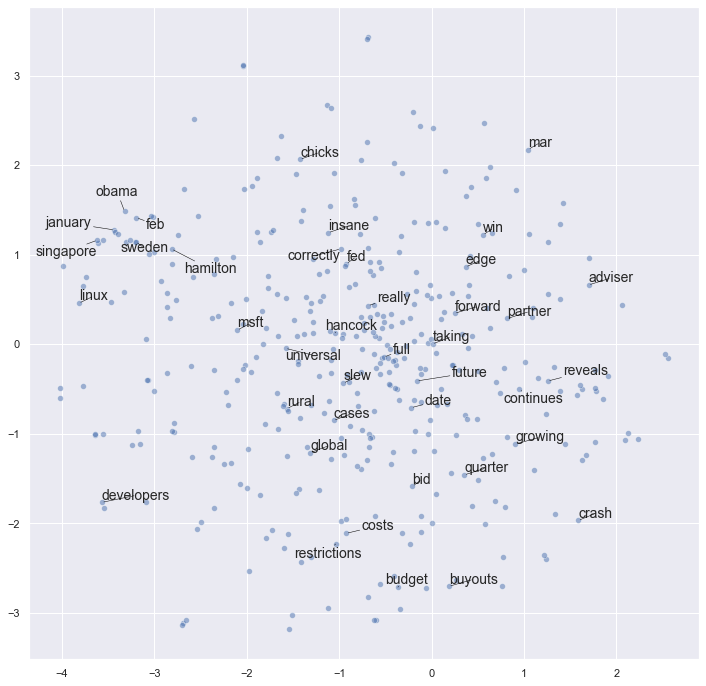

In [19]:
# defines parameters globally while creating a plot
sns.set()

# Initialize figure
fig, ax = plt.subplots(figsize = (12, 12))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
# adjust_text is used to push words apart for readability
from adjustText import adjust_text
texts = []                                    # empty list
words_to_plot = list(np.arange(0, 400, 10))   
# starting interval:0,ending interval:400, spacing wbetween each value:10

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

In [23]:
# the above plot helps identifying some similarities and patterns.
# We have the months and the names of people in the upper left part of the plot
# a few corporate-finance terms like costs, buyouts and budgets in the bottom part
# generic words in the center of the plot; like slew, full, taking, really,etc

In [24]:
# Now we'll try to find titles that cluster together and identify the patterns
# we re-do the preprocessing step to keep the titles intact
# these functions are used from --> https://github.com/sdimi/average-word2vec/blob/master/notebook.ipynb


def document_vector(word2vec_model, doc):
# remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes
    a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [25]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in Word2vector's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))
# lambda is an implicit way of defining function, not bound to a specific name

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))

37 docs removed
0 docs removed


In [26]:
# Initialize an array for the size of the corpus
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

In [28]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])

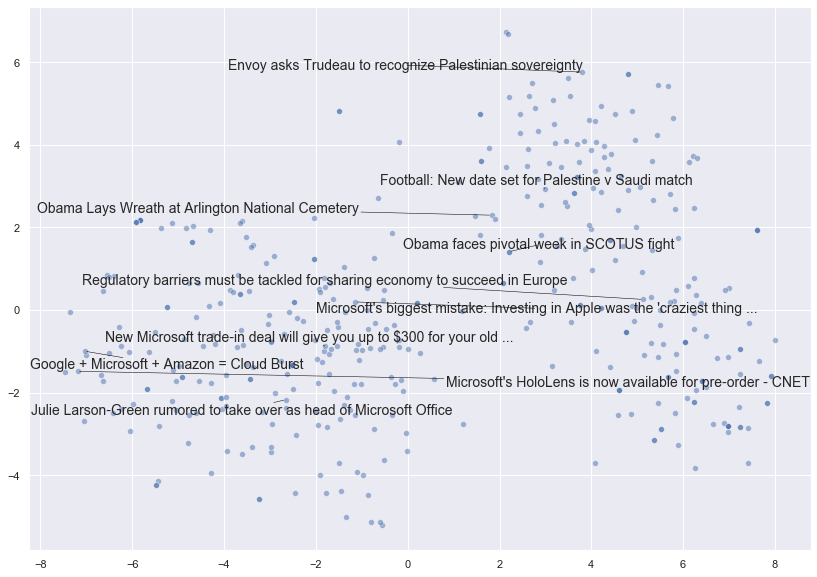

In [29]:
#this time plotting the titles
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Second plot: Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
titles_to_plot = list(np.arange(0, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

In [30]:
# the plot represents the document vectors, collapsed into a dimensional space.
# the contents displayed are of various types like countries, technology companies, world leaders, foreign affairs, etc

In [31]:
## Now performing Popularity and Sentiment Analysis

# Drop all the rows where the article popularities are unknown (this is only about 11% of the data)
main_data = main_data.drop(main_data[(main_data.Facebook == -1) | 
                                     (main_data.GooglePlus == -1) | 
                                     (main_data.LinkedIn == -1)].index)

# Also drop all rows where we don't know the source
# Moreover this cleansing of data
main_data = main_data.drop(main_data[main_data['Source'].isna()].index)

main_data.shape

(81417, 11)

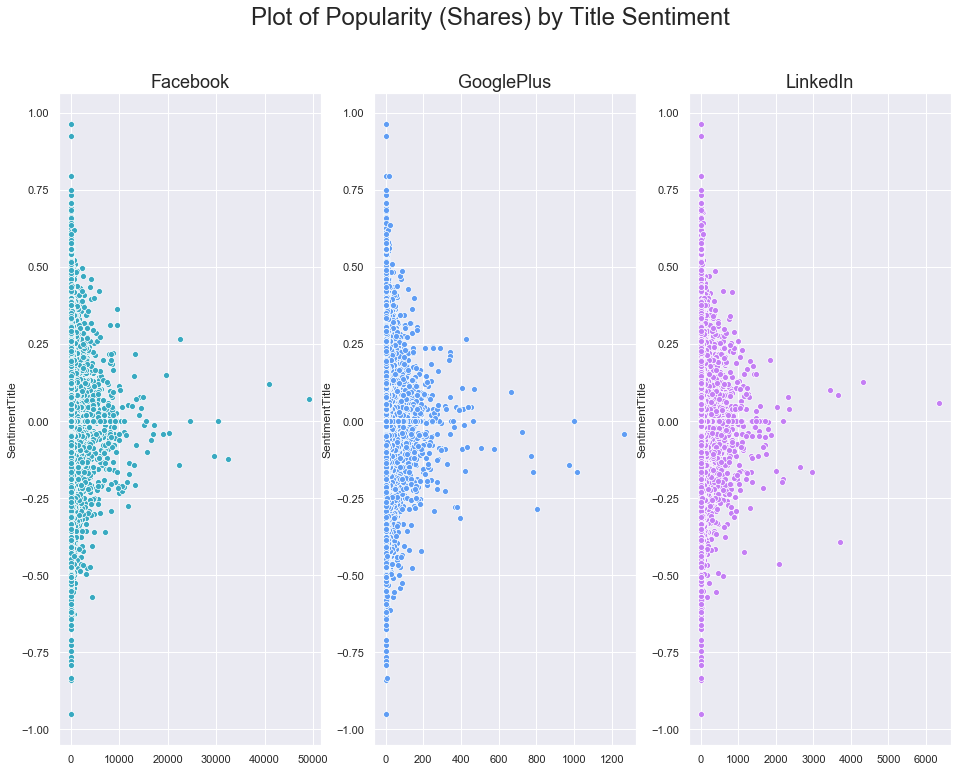

In [37]:
## POPULARITY ANALYSIS ##
fig, ax = plt.subplots(1, 3, figsize=(16,12))

subplots = [a for a in ax]
platforms = ['Facebook', 'GooglePlus', 'LinkedIn']
colors = list(sns.husl_palette(10, h=.5)[1:4]) 

for platform, subplot, color in zip(platforms, subplots, colors):
    sns.scatterplot(x = main_data[platform], y = main_data['SentimentTitle'], ax=subplot, color=color)
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity (Shares) by Title Sentiment', fontsize=24)

plt.show()

In [38]:
# there are significant number of outliers for each share

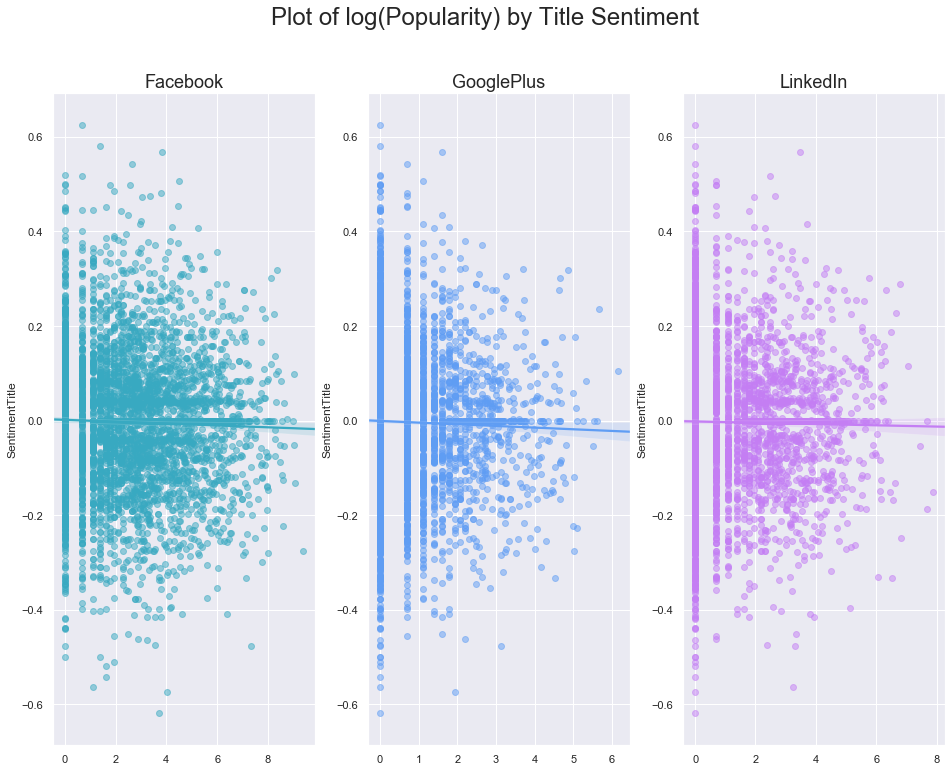

In [40]:
# Our data has over 80,000 rows, so let's subsample it to make the log-transformed scatterplot easier to read

subsample = main_data.sample(5000)

fig, ax = plt.subplots(1, 3, figsize=(16, 12))

subplots = [a for a in ax]

for platform, subplot, color in zip(platforms, subplots, colors):
    # Regression plot, so we can gauge the linear relationship
    sns.regplot(x = np.log(subsample[platform] + 1), y = subsample['SentimentTitle'], 
                ax=subplot, 
                color=color,
                # Pass an alpha value to regplot's scatterplot call
                scatter_kws={'alpha':0.5})
    
    # Set a nice title, get rid of x labels
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of log(Popularity) by Title Sentiment', fontsize=24)

plt.show()

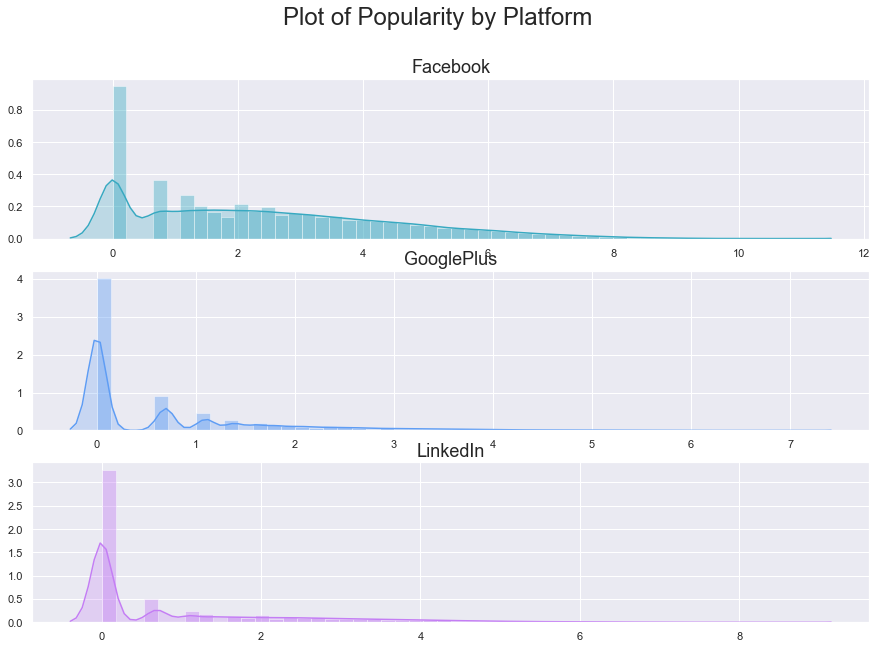

In [41]:
# A plot by platform
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

subplots = [a for a in ax]

for platform, subplot, color in zip(platforms, subplots, colors):
  
    sns.distplot(np.log(main_data[platform] + 1), ax=subplot, color=color, kde_kws={'shade':True})
    
    # Set a nice title, get rid of x labels
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity by Platform', fontsize=24)

plt.show()

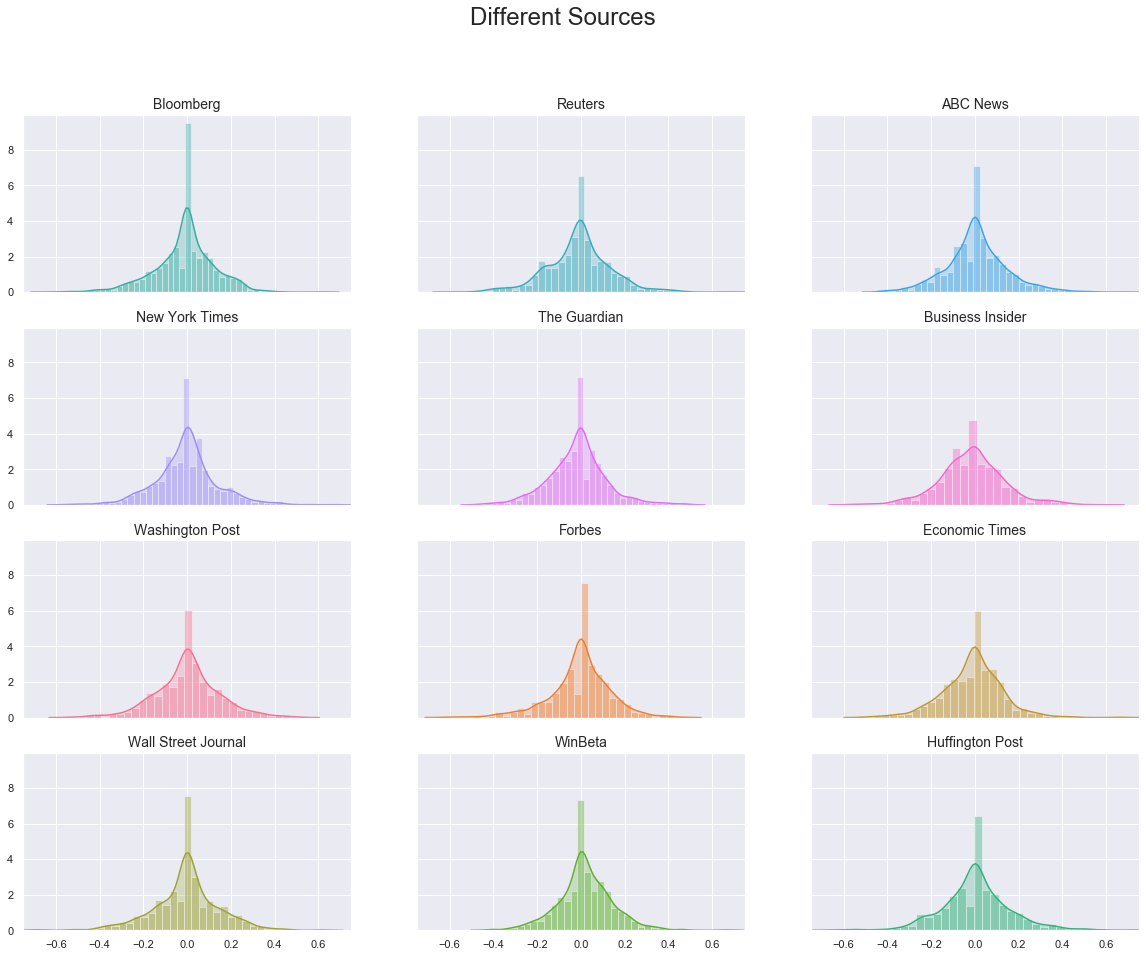

In [45]:
## SENTIMENT ANALYSIS ##
# Get the list of top 12 sources by number of articles
source_names = list(main_data['Source'].value_counts()[:12].index)
source_colors = list(sns.husl_palette(12, h=.5))

fig, ax = plt.subplots(4, 3, figsize=(20, 15), sharex=True, sharey=True)

ax = ax.flatten()
for ax, source, color in zip(ax, source_names, source_colors):
    sns.distplot(main_data.loc[main_data['Source'] == source]['SentimentTitle'],
                               ax=ax, color=color, kde_kws={'shade':True})
    ax.set_title(source, fontsize=14)
    ax.set_xlabel('')
    
fig.suptitle('Different Sources', fontsize=24)
    
plt.xlim(-0.75, 0.75)
plt.show()

In [47]:
# the distribution looks similar, let's overlay the plot

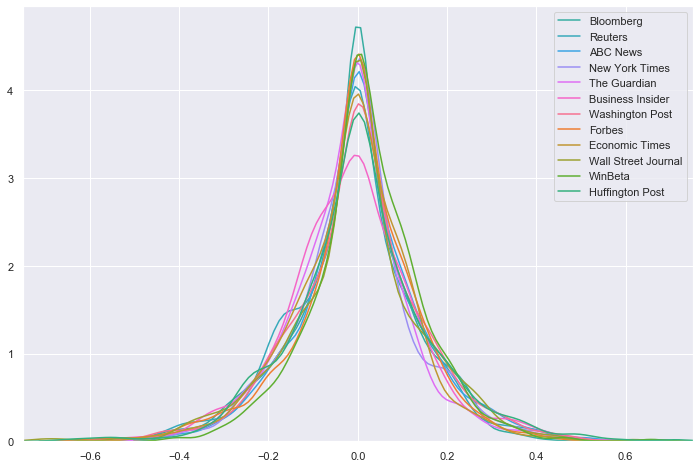

In [48]:
# Overlay each density curve on the same plot for closer comparison
fig, ax = plt.subplots(figsize=(12, 8))

for source, color in zip(source_names, source_colors):
    sns.distplot(main_data.loc[main_data['Source'] == source]['SentimentTitle'],
                               ax=ax, hist=False, label=source, color=color)
    ax.set_xlabel('')
    
plt.xlim(-0.75, 0.75)
plt.show()

In [50]:
# Group by Source, then get descriptive statistics for title sentiment
source_info = main_data.groupby('Source')['SentimentTitle'].describe()
# source_names contains the top 12 sources

# We'll also sort by highest standard deviation
source_info.loc[source_names].sort_values('std', ascending=False)[['std', 'min', 'max']]

,std,min,max
Source,,,
Huffington Post,0.1581,-0.6443,0.7115
Wall Street Journal,0.1524,-0.7115,0.6179
Business Insider,0.1483,-0.5573,0.5737
Washington Post,0.1466,-0.5303,0.5043
Reuters,0.1459,-0.5856,0.6765
New York Times,0.1419,-0.5559,0.6629
ABC News,0.1417,-0.4249,0.7955
Forbes,0.1386,-0.6187,0.4551
Bloomberg,0.1384,-0.6327,0.6124


Text(0.5, 0.98, 'Plot of Popularity by Platform')

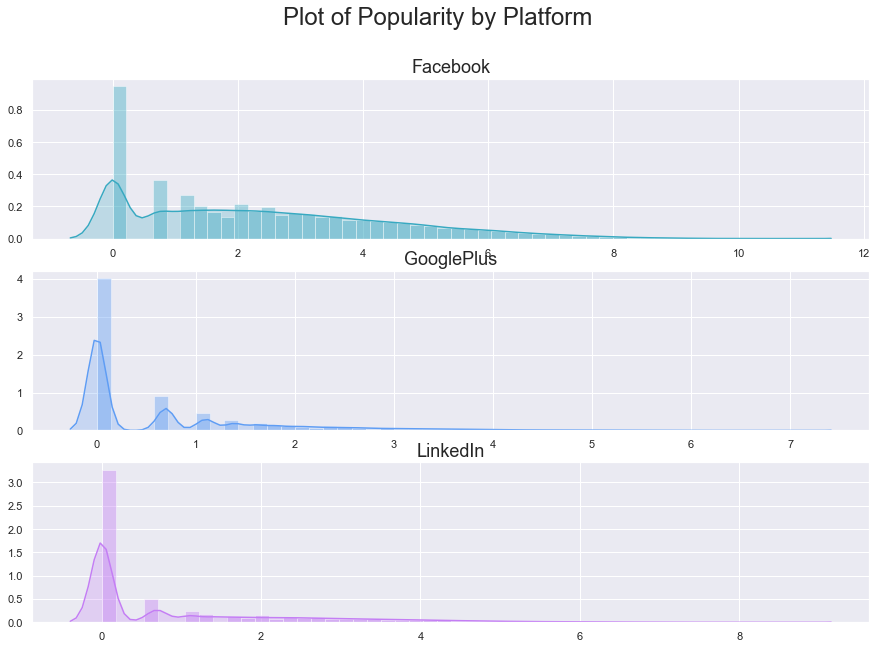

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

subplots = [a for a in ax]

for platform, subplot, color in zip(platforms, subplots, colors):
  
    sns.distplot(np.log(main_data[platform] + 1), ax=subplot, color=color, kde_kws={'shade':True})
    
    # Set a nice title, get rid of x labels
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity by Platform', fontsize=24)